<a href="https://colab.research.google.com/github/Dare-Badejo-001/Optimization-Problems/blob/main/Least_absolute_Deviation(LAD)_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [2]:
# Here we create a dataset

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression

n_features = 1
n_samples = 1000
noise = 30

np.random.seed(2021)
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

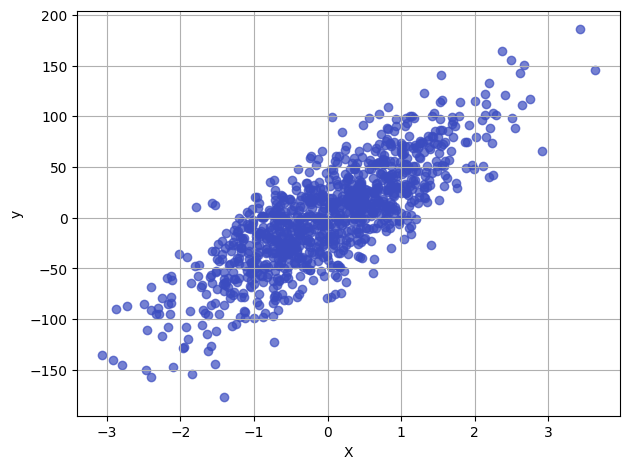

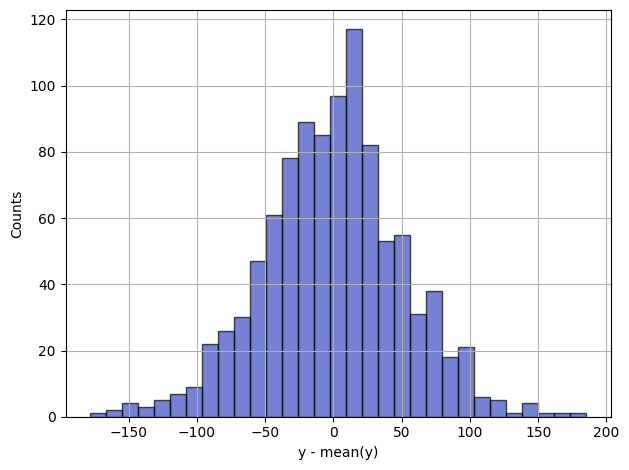

In [3]:
# check the dataset
if n_features == 1:
    fig, ax = plt.subplots()
    ax.scatter(X, y, alpha=0.7, color=plt.get_cmap("coolwarm")(0))
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

fig2, ax2 = plt.subplots()
ax2.hist(
    y - np.mean(y),
    bins=int(np.sqrt(len(y))),
    color=plt.get_cmap("coolwarm")(0),
    alpha=0.7,
    edgecolor="black",
)
ax2.set_ylabel("Counts")
ax2.set_xlabel("y - mean(y)")
ax2.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def lad_regression(X, y):
    model = pyo.ConcreteModel("LAD Regression")

    # get dimensions of data
    n, k = X.shape

    # create index sets (note use of Python style zero based indexing)
    model.I = pyo.RangeSet(0, n - 1)
    model.J = pyo.RangeSet(0, k - 1)

    # create variables
    model.ep = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.em = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.m = pyo.Var(model.J)
    model.b = pyo.Var()

    # constraints
    @model.Constraint(model.I)
    def residuals(m, i):
        return m.ep[i] - m.em[i] == y[i] - sum(X[i][j] * m.m[j] for j in m.J) - m.b

    # objective
    @model.Objective(sense=pyo.minimize)
    def sum_of_abs_errors(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)

    SOLVER.solve(model)

    return model


model = lad_regression(X, y)
print(
    f"Optimal solution: m = {[f'{model.m[j].value:.2f}' for j in model.J][0]} and b = {model.b.value:.2f}")

print(f"Objective value: {pyo.value(model.sum_of_abs_errors):.2f}")

Optimal solution: m = 39.66 and b = 1.14
Objective value: 24276.10


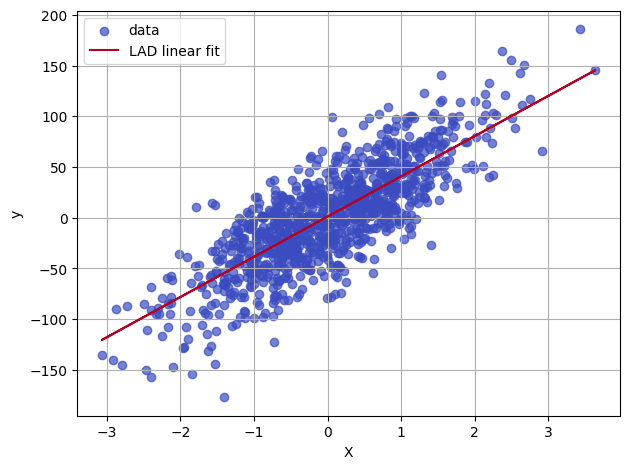

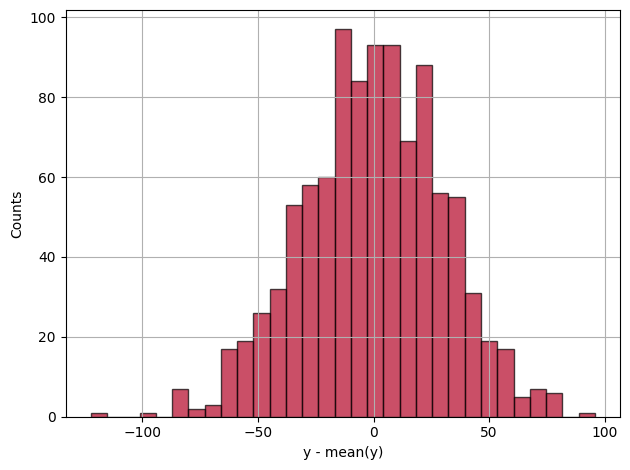

In [5]:
y_fit = np.array([sum(x[j] * model.m[j]() for j in model.J) + model.b() for x in X])

if n_features == 1:
    fig, ax = plt.subplots()
    ax.scatter(X, y, alpha=0.7, color=plt.get_cmap("coolwarm")(0), label="data")
    ax.plot(X, y_fit, color=plt.get_cmap("coolwarm")(1.0), label="LAD linear fit")
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

fig2, ax2 = plt.subplots()
ax2.hist(
    y - y_fit,
    bins=int(np.sqrt(len(y))),
    color=plt.get_cmap("coolwarm")(1.0),
    alpha=0.7,
    edgecolor="black",
)
ax2.set_ylabel("Counts")
ax2.set_xlabel("y - mean(y)")
ax2.grid(True)
plt.tight_layout()
plt.show()